<a href="https://colab.research.google.com/github/KacperGrodecki/nieruchomosci-mazowieckie/blob/0.0.1/mazowieckie_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn import svm
import pandas as pd
import numpy as np
np.random.seed(7)
from google.colab import drive
import seaborn as sns
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import pandas as pd
#from otoDomScraper import daneDomu
#from random import randrange
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import statistics
from sklearn.cluster import AffinityPropagation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.decomposition import FastICA
from sklearn import preprocessing
from IPython.display import Javascript
import requests
from collections import OrderedDict

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
def toNum2(txt):
    if type(txt) is int:
        return txt
    elif (type(txt) is str):
        digs = re.findall(r'\d+', txt)
        if len(digs) == 1:
            return int(digs[0])
        elif len(digs) == 2:
            return 1000 * int(digs[0]) + int(digs[1])
        elif len(digs) == 3:
            return 1000000 * int(digs[0]) + 1000 * int(digs[1]) + int(digs[0])

    #   return int(digs)


def toNum1(txt):
    if type(txt) is str:
        digs = re.findall(r'\d+', txt)
        if len(digs) == 1:
            return int(digs[0])
        elif len(digs) == 2 and (txt[1] != ' '):
            return int(digs[0]) + 0.01 * int(digs[1])
        elif len(digs) == 3:
            return 1000 * int(digs[0]) + int(digs[1]) + 0.001 * int(digs[2])
        elif (type(txt) is str) and (txt[1] == ' '):
            digs = re.findall(r'\d+', txt)
            return 1000 * int(digs[0]) + int(digs[1])
    else:
        return txt


def toNum3(txt):
    if type(txt) == int:
        return txt
    return int(re.findall(r'\d+', txt)[0])

def pietra(txt):
    if type(txt) is str:
        if '0' in txt:
            return 0
        if '1' in txt:
            return 1
        elif '2' in txt:
            return 2
        elif '3' in txt:
            return 3
        elif 'parterowy' in txt:
            return 0
    else:
        return txt

def cities(x):
    dist=x.split()[4]
    #city=x.split()[5]
    if dist=='warszawski':
        return x.split()[6]
    elif dist in ['Warszawa','Radom','Płock','Siedlce']:
        return dist
    else:
        try:
            return x.split()[5]
        except:
            return 'unknown'

def region(x):
    if x.split()[4]=='Warszawa':
        try:
            return x.split()[5]
        except:
            return ''
    else:
        return ''

In [3]:
def get_voivodeships():
    # problem - too many voivodeships, historical ones are mixed together
    # solution - just cut the list after 16-th item
    
    # request voivodeships of poland(wd:Q36),
    # cut after 16 voivodeships, the rest are historical ones
    # https://query.wikidata.org/#%20%20%20%20SELECT%20%3Fvoivodeship%20%3FvoivodeshipLabel%20%3Flatitude%20%3Flongitude%20%3Fadmininistrative_teritorial_entity%0A%20%20%20%20WHERE%20%7B%0A%20%20%20%20%20%20%3Fvoivodeship%20wdt%3AP31%20wd%3AQ150093%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP131%20%3Fadmininistrative_teritorial_entity%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20p%3AP625%2Fpsv%3AP625%20%5B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLatitude%20%3Flatitude%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLongitude%20%3Flongitude%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5D.%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20FILTER%28%3Fadmininistrative_teritorial_entity%20%3D%20wd%3AQ36%29.%0A%20%20%20%20%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22pl%22.%20%7D%0A%20%20%20%20%7D%0A%20%20%20%20ORDER%20BY%20DESC%28%3Fvoivodeship%29%0A%20%20%20%20LIMIT%2016%0A
    url = 'https://query.wikidata.org/sparql'
    query = '''
    SELECT ?voivodeship ?voivodeshipLabel ?latitude ?longitude ?admininistrative_teritorial_entity
    WHERE {
      ?voivodeship wdt:P31 wd:Q150093;
                   wdt:P131 ?admininistrative_teritorial_entity;
                   p:P625/psv:P625 [
                       wikibase:geoLatitude ?latitude ;
                       wikibase:geoLongitude ?longitude ;
                   ].               
      FILTER(?admininistrative_teritorial_entity = wd:Q36).
      SERVICE wikibase:label { bd:serviceParam wikibase:language "pl". }
    }
    ORDER BY DESC(?voivodeship)
    LIMIT 16
    '''
    r = requests.get(url, params = {'format': 'json', 'query': query})
    data = r.json()

    # convert json to dataframe
    voivodeships = []
    for item in data['results']['bindings']:
        voivodeships.append(OrderedDict(
        {
            'voivodeship':      item['voivodeshipLabel']['value'].lower(),
            'latitude':         float(item['latitude']['value']),        
            'longitude':        float(item['longitude']['value']),                    
            'wikidata_item_id': item['voivodeship']['value'].split('/')[-1]
        }))
    #     print(item,'\n')    
    
    df = pd.DataFrame(voivodeships)
    return df


In [4]:
def get_warsaw_districts():
    # problem  - some districts have two sets of coordinates which differ slighlty
    # solution - drop the one with worse precision (larger value), this seems to be consistent with the wikipedia data
    # to do    - the above is not true for ['Wola'], change it
    
    # https://query.wikidata.org/#SELECT%20%3Fdistrict_of_Warsaw%20%3Fdistrict_of_WarsawLabel%20%3Flat%20%3Flon%20%3FgeoPrecision%20%0AWHERE%20%7B%0A%20%20%3Fdistrict_of_Warsaw%20%20wdt%3AP31%20wd%3AQ4286337%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP17%20wd%3AQ36%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP131%20wd%3AQ270%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20p%3AP625%2Fpsv%3AP625%20%5B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLatitude%20%3Flat%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoLongitude%20%3Flon%20%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wikibase%3AgeoPrecision%20%20%3FgeoPrecision%3B%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5D%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22pl%22.%20%7D%0A%7D
    url = 'https://query.wikidata.org/sparql'
    query = '''
    SELECT ?warsaw_district ?warsaw_districtLabel ?latitude ?longitude ?geoPrecision 
    WHERE {
      ?warsaw_district  wdt:P31 wd:Q4286337;
                           wdt:P17 wd:Q36;
                           wdt:P131 wd:Q270;
                           p:P625/psv:P625 [
                               wikibase:geoLatitude ?latitude ;
                               wikibase:geoLongitude ?longitude ;
                               wikibase:geoPrecision  ?geoPrecision;                                       
                           ]
      SERVICE wikibase:label { bd:serviceParam wikibase:language "pl". }
    }
    ORDER BY ASC(?warsaw_districtLabel)
    '''
    r = requests.get(url, params = {'format': 'json', 'query': query})
#     print(r.json())
    data = r.json()

    # convert json to dataframe
    warsaw_districts = []
    for item in data['results']['bindings']:
#         print(item,'\n')    
        warsaw_districts.append(OrderedDict(
        {
            'warsaw_district':  item['warsaw_districtLabel']['value'].lower(),
            'latitude':         float(item['latitude']['value']),        
            'longitude':        float(item['longitude']['value']),                    
            'geoPrecision':     float(item['geoPrecision']['value']),                                
            'wikidata_item_id': item['warsaw_district']['value'].split('/')[-1]
        }))
    
    warsaw_districts = pd.DataFrame(warsaw_districts).sort_values(by=['warsaw_district'])
    
    # if duplicate warsaw districts exist, take the one with better precision (lower value), do the opposite in case of 'Wola' 
    for district in warsaw_districts['warsaw_district']:
        if np.sum(warsaw_districts['warsaw_district'] == district) > 1: # duplicate district found
            if district != 'wola':            
                district_to_drop_idx = warsaw_districts.loc[warsaw_districts['warsaw_district'] == district, 'geoPrecision'].idxmax()
            elif district == 'wola':
                district_to_drop_idx = warsaw_districts.loc[warsaw_districts['warsaw_district'] == district, 'geoPrecision'].idxmin()
#             print(district+':\t', district_to_drop_idx, '\n')
            warsaw_districts = warsaw_districts.drop(district_to_drop_idx).reset_index(drop=True)  
            
    return warsaw_districts

In [50]:
def return_coordinates(place):
    '''
    Returns coordinates of the place.
        The place must be the name (in polish) of voivodeship in Poland or the district of Warsaw.
    E.g.:
      1)
        In:  return_coordinates('województwo podlaskie')
        Out: [53.267219444444, 22.931938888889]
      2) 
        In:  return_coordinates('podlaskie')
        Out: [53.267219444444, 22.931938888889]
      3)
        In:  return_coordinates('PODLASKIE')
        Out: [53.267219444444, 22.931938888889]
      4) 
        In:  return_coordinates('Ursus')
        Out: [52.19517, 20.88419] 
    '''
    print('return_coordinates ',place)
    coordinates = [None, None]
    place = place.lower()
    print('error 1')
    try:
        voivodeships = get_voivodeships()
        coordinates_df = voivodeships.loc[voivodeships['voivodeship'].str.contains(place) == True, ['latitude', 'longitude']]
        coordinates = coordinates_df.values.tolist()[0]       
        print('pass 1')
    except IndexError:
        try:
            warsaw_districts = get_warsaw_districts()
            coordinates_df = warsaw_districts.loc[warsaw_districts['warsaw_district'].str.contains(place) == True, ['latitude', 'longitude']]
            coordinates = coordinates_df.values.tolist()[0]
            print('pass 2')
        except IndexError:
            print('error 3')
            pass
    return coordinates

In [8]:
def makeDataFrame(file):
    dfMazowieckie=pd.read_csv(file,index_col=0)
    concat=dfMazowieckie
    concat['powierzchnia_corr'] = concat['powierzchnia'].apply(lambda x: toNum1(x))
    concat['powierzchniaDzialki_corr'] = concat['powierzchniaDzialki'].apply(lambda x: toNum2(x))
    concat['cena_corr'] = concat['cena'].apply(lambda x: toNum2(x))
    concat['rokBudowy_corr'] = concat['rokBudowy'].apply(lambda x: toNum3(x))
    concat['cena/m'] = concat['cena_corr'] / concat['powierzchnia_corr']
    concat['lPieter_crr'] = concat['lPieter'].apply(lambda x: pietra(x))
    concat = concat[concat['powierzchnia_corr'] > 0]
    concat = concat[concat['cena_corr'] > 0]
    concat['lPokoi'] = concat['lPokoi'].apply(lambda x: toNum3(x))
    concat['districts']=concat['dzielnica'].apply(lambda x: x.split()[4])
    cities_corr=concat['dzielnica'].apply(lambda x: cities(x))
    concat['cities_corr']=cities_corr
    region_corr=concat['dzielnica'].apply(lambda x: region(x))
    concat['region_corr']=region_corr
    concat_dropped = concat.drop(['dzielnica', 'powierzchnia', 'powierzchniaDzialki', 'lPieter', 'cena', 'cena_corr',], axis=1)
    concat_dropped['rokBudowy'] = concat_dropped['rokBudowy'].replace(to_replace=0, value=1990)
    concat_dropped['rokBudowy'] = concat_dropped['rokBudowy'].astype('int')
    concat_dropped = concat_dropped.fillna(0)
    concat_dropped = concat_dropped[concat_dropped['cena/m'] < 20000]
    concat_dropped['cena/m'].hist(bins=200)
    concat_dropped_dumm = pd.get_dummies(concat_dropped, columns=['rodzajZabudowy', 'materialBudynku', 'stanWykonczenia', 'okna', 'rynek',
                                           'cities_corr','districts','region_corr'])
    return concat_dropped_dumm,concat_dropped

In [9]:
filename='/content/drive/My Drive/domy mazowieckie/dfMazowieckie.csv'

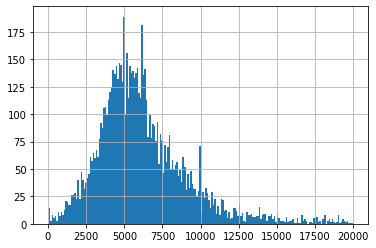

In [13]:
concat_dropped_dumm,concat_dropped=makeDataFrame(filename)

In [17]:
concat_dropped.head(20)

,lPokoi,rodzajZabudowy,materialBudynku,rokBudowy,stanWykonczenia,okna,rynek,powierzchnia_corr,powierzchniaDzialki_corr,rokBudowy_corr,cena/m,lPieter_crr,districts,cities_corr,region_corr
0,6,wolnostojący,cegła,2019,do wykończenia,0,wtórny,320.00,1000,2019,6062.503125,1,Warszawa,Warszawa,Wesoła
1,5,0,beton komórkowy,2021,do wykończenia,plastikowe,pierwotny,154.00,750,2021,5186.363636,0,grodziski,Milanówek,
2,3,wolnostojący,0,1950,do remontu,0,wtórny,80.00,2356,1950,5612.500000,1,nowodworski,Nowy,
3,4,bliźniak,silikat,2022,do wykończenia,plastikowe,pierwotny,152.91,220,2022,4250.866523,1,piaseczyński,Nowa,
4,4,wolnostojący,pustak,2020,stan surowy otwarty,brak,pierwotny,106.00,960,2020,2924.528302,0,płocki,Słupno,
5,6,wolnostojący,0,2011,do zamieszkania,plastikowe,wtórny,160.00,2500,2011,8906.256250,1,grodziski,Marynin,
6,4,szeregowiec,0,2021,do wykończenia,plastikowe,pierwotny,135.00,190080,2021,5111.111111,1,otwocki,Wiązowna,
7,4,wolnostojący,inne,1989,do zamieszkania,0,wtórny,320.00,1400,1989,5312.503125,0,żyrardowski,Józefów,
8,7,bliźniak,cegła,2008,do zamieszkania,plastikowe,wtórny,266.00,465,2008,7142.860902,1,Warszawa,Warszawa,Włochy
9,6,0,cegła,2019,do wykończenia,0,pierwotny,270.00,900,2019,7407.414815,0,Warszawa,Warszawa,Ursynów


In [51]:
concat_dropped.cities_corr.apply(lambda x: return_coordinates(x))

return_coordinates  Warszawa
error 1
error 3
return_coordinates  Milanówek
error 1
error 3
return_coordinates  Nowy
error 1
error 3
return_coordinates  Nowa
error 1
error 3
return_coordinates  Słupno
error 1
error 3
return_coordinates  Marynin
error 1


JSONDecodeError: ignored

In [40]:
return_coordinates('Wola')

return_coordinates  Wola


[52.233333333333, 20.957222222222]

In [128]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=20,random_state=0)
x_tr = transformer.fit_transform(concat_dropped_dumm.drop(['cena/m'],axis=1).values)

In [129]:
pd_x_tr=pd.DataFrame(x_tr)

In [130]:
pd_x_tr['cena/m']=concat_dropped_dumm['cena/m']
pd_x_tr= pd_x_tr.fillna(0)

In [131]:
pd_x_tr.columns=['a0','a1','a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','cena/m',]

In [132]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(pd_x_tr.values)
df = pd.DataFrame(x_scaled,columns=['a0','a1','a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','cena/m',])
df  = df.fillna(0)

In [161]:
df.head()

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,cena/m
0,0.000142,0.538168,0.960679,0.124256,0.963230,0.201166,0.577541,0.838554,0.874352,0.864407,0.669552,0.855231,0.578469,0.777769,0.994382,0.136624,0.654157,0.878563,0.818298,0.584550,0.303559
1,0.000221,0.067467,0.961486,0.755807,0.810324,0.500746,0.585708,0.771617,0.506184,0.712844,0.572349,0.576593,0.548809,0.841463,0.994276,0.708190,0.764086,0.201298,0.806505,0.556634,0.259689
2,0.000174,0.580600,0.969335,0.238737,0.854292,0.914767,0.409551,0.723284,0.933732,0.871902,0.734715,0.280551,0.655080,0.739266,0.994164,0.146112,0.502043,0.866283,0.711063,0.611030,0.281026
3,0.000202,0.808070,0.956856,0.169802,0.830681,0.534666,0.472344,0.143991,0.495246,0.676274,0.533429,0.592232,0.609226,0.838978,0.994351,0.795495,0.655343,0.153414,0.850874,0.555981,0.212847
4,0.000225,0.491747,0.964443,0.156760,0.561536,0.521172,0.588678,0.760030,0.276864,0.121652,0.724362,0.393098,0.676338,0.801216,0.994720,0.120101,0.685216,0.540374,0.785667,0.565439,0.146435


In [160]:
pd_x_tr.head()

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19
0,-0.000177,-0.001001,0.000577,-0.006818,0.009628,-0.012993,0.002223,0.007161,0.022403,0.005653,0.002857,0.018774,0.004134,0.001549,0.000612,-0.010485,0.011355,0.014473,0.010364,0.004863
1,-0.000097,-0.024244,0.000827,0.026696,0.003123,-0.001496,0.002967,0.003909,-0.001205,-0.001537,-0.003566,0.005834,0.001650,0.005562,0.000537,0.010139,0.018199,-0.010465,0.009876,0.003027
2,-0.000144,0.001095,0.003265,-0.000743,0.004993,0.014393,-0.013073,0.001560,0.026210,0.006008,0.007162,-0.007914,0.010551,-0.000877,0.000458,-0.010143,0.001884,0.014021,0.005931,0.006605
3,-0.000116,0.012327,-0.000610,-0.004401,0.003989,-0.000194,-0.007356,-0.026583,-0.001906,-0.003272,-0.006137,0.006560,0.006710,0.005405,0.000590,0.013290,0.011429,-0.012228,0.011711,0.002984
4,-0.000094,-0.003293,0.001746,-0.005093,-0.007463,-0.000712,0.003237,0.003346,-0.015909,-0.029581,0.006478,-0.002687,0.012332,0.003026,0.000852,-0.011081,0.013289,0.002020,0.009015,0.003606


In [135]:
!pip install tensorflow_decision_forests

In [136]:
!pip install wurlitzer

In [137]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [138]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)


Found TensorFlow Decision Forests v0.1.8


In [139]:
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [140]:
train_ds_pd, test_ds_pd = split_dataset(df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))


5435 examples in training, 2388 examples for testing.


alternatywna macierz bez min max scaller

In [141]:
train_ds_pd, test_ds_pd = split_dataset(pd_x_tr)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))


5428 examples in training, 2395 examples for testing.


In [142]:
#train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
Task = tf_core.Task
train_ds=tfdf.keras.pd_dataframe_to_tf_dataset(
    train_ds_pd,
    label='cena/m',
    task=Task.REGRESSION
)

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_ds_pd,
    label='cena/m',
    task=Task.REGRESSION
)

In [143]:
# A classical but slighly more complex model.
model_tune = tfdf.keras.GradientBoostedTreesModel(
    task=Task.REGRESSION,num_trees=2000, growing_strategy="BEST_FIRST_GLOBAL", max_depth=2000)
model_tune.compile(
    metrics=['mse',"mae",'acc'])
model_tune.fit(train_ds)

85/85 [==============================] - 0s 2ms/step


In [144]:
evaluation = model_tune.evaluate(train_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print('alsolute ',f"{name}: {value:.4f}")
  print('relative ',f"{name}: {100*value/df['cena/m'].mean():.4f}")

85/85 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - mse: 10433617.0000 - mae: 2355.9512 - acc: 0.0000e+00

alsolute  loss: 0.0000
relative  loss: 0.0000
alsolute  mse: 10433617.0000
relative  mse: 3566152226.3783
alsolute  mae: 2355.9512
relative  mae: 805250.9994
alsolute  acc: 0.0000
relative  acc: 0.0000


In [145]:
evaluation = model_tune.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print('alsolute ',f"{name}: {value:.4f}")
  print('relative ',f"{name}: {100*value/df['cena/m'].mean():.4f}")

38/38 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mse: 11419883.0000 - mae: 2484.3499 - acc: 0.0000e+00

alsolute  loss: 0.0000
relative  loss: 0.0000
alsolute  mse: 11419883.0000
relative  mse: 3903252456.5000
alsolute  mae: 2484.3499
relative  mae: 849136.9543
alsolute  acc: 0.0000
relative  acc: 0.0000


In [146]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)


2.5.0


In [ ]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('cena/m')
test_labels = test_features.pop('cena/m')

In [ ]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [202]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_absolute_error',metrics=['mae','mse'],
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [203]:
dnn_model = build_and_compile_model(normalizer)

In [204]:
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 20)                41        
_________________________________________________________________
dense_30 (Dense)             (None, 32)                672       
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 17        
Total params: 1,258
Trainable params: 1,217
Non-trainable params: 41
_________________________________________________________________


In [205]:
history = dnn_model.fit(
    train_features, train_labels,
    validation_split = 0.2,
    verbose=0, epochs=50)


In [206]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(history.history['mae'], label='mae')
  plt.plot(history.history['val_mae'], label='val_mae')
  plt.plot(history.history['mse'], label='mse')
  plt.plot(history.history['val_mse'], label='val_mse')
  plt.ylim([0, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


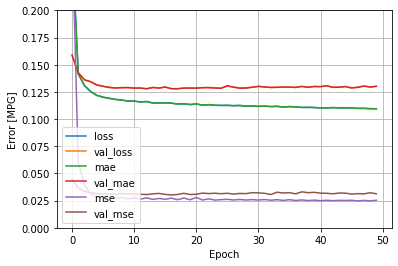

In [207]:
plot_loss(history)

In [214]:
rel=df['cena/m'].mean()

In [218]:
np.array(history.history['mae'])/rel

array([0.89642092, 0.48403536, 0.44706735, 0.4282523 , 0.41629189,
       0.41065287, 0.40700795, 0.40354602, 0.4015818 , 0.398488  ,
       0.39839378, 0.39558993, 0.39686146, 0.39226511, 0.39267841,
       0.39270958, 0.39191523, 0.38895014, 0.38976456, 0.3874388 ,
       0.38947924, 0.38556914, 0.38722219, 0.38518967, 0.38474986,
       0.38499756, 0.38388993, 0.38461558, 0.38257218, 0.38292033,
       0.3817774 , 0.38258774, 0.38111   , 0.38180725, 0.37957882,
       0.38111781, 0.37979411, 0.37845899, 0.37866028, 0.37812264,
       0.37700065, 0.37700434, 0.37784693, 0.37723539, 0.37693808,
       0.37681827, 0.37540574, 0.37550605, 0.37451844, 0.37428568])

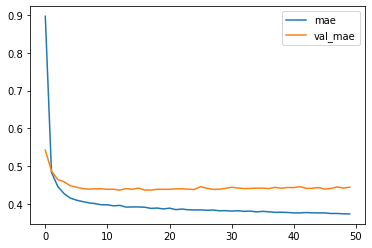

In [221]:
plt.plot(np.array(history.history['mae'])/rel, label='mae')
plt.plot(np.array(history.history['val_mae'])/rel, label='val_mae')
plt.legend()